# Running depths

To produce accurate flux errors for each source detected in our source extraction procedure, we require an estimate of the local image depth. To do this, we place a large number of apertures of the same size as measured in our forced photometry catalogues in the blank regions of our image, as defined by the region outside of the stacked segmentation and manual/automated mask boolean fits arrays. A ds9 region file is created in this process so that the user can ensure that the regions used in the local depth calculation are indeed in 'blank' regions.

For each source in the catalogue, we need to determine which blank apertures to define as being 'local'. There are two different methods (selected by the `mode` argument) that we use to do this: 

1. `n_nearest`: the n closest apertures to the source (default)
2. `rolling`: all apertures within a specific radius from the source

Once these apertures have been selected, we take the un-aperture corrected fluxes and calculate their normalized median absolute deviation (NMAD) as follows

$\mathrm{NMAD}=1.4826 * \mathrm{median}(\mid f_{\nu, i} - \langle f_{\nu, i} \rangle \mid)$

This gives a $1\sigma$ flux error, which can easily be converted to a standard $5\sigma$ depth in AB magnitudes.

The data output is in a .h5 format and once saved can be accessed via the Data class to plot depth diagnostics, update the catalogue with more appropriate flux errors which take into account the correlated noise in the image, and more. We will cover this in the second example. For now though, we will focus on first calculating depths for our JOF dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from matplotlib import cm
from pathlib import Path
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from galfind import Data
from galfind.Data import morgan_version_to_dir

survey = "JOF"
version = "v11"
instrument_names = ["NIRCam"]
aper_diams = [0.32] * u.arcsec #, 0.5, 1.0, 1.5, 2.0
forced_phot_band = ["F277W", "F356W", "F444W"]

JOF_data = Data.from_survey_version(
    survey=survey,
    version=version,
    instrument_names=instrument_names,
    version_to_dir_dict=morgan_version_to_dir,
    aper_diams=aper_diams,
    forced_phot_band=forced_phot_band,
)
JOF_data.mask()
JOF_data.segment()
JOF_data.perform_forced_phot()

Reading GALFIND config file from: /nvme/scratch/work/austind/GALFIND/galfind/../configs/galfind_config.ini


INFO:galfind:Aperture corrections for ACS_WFC loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/ACS_WFC_aper_corr.txt
INFO:galfind:Aperture corrections for WFC3_IR loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/WFC3_IR_aper_corr.txt
INFO:galfind:Aperture corrections for NIRCam loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/NIRCam_aper_corr.txt
INFO:galfind:Aperture corrections for MIRI loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/MIRI_aper_corr.txt
INFO:galfind:Aperture corrections for ACS_WFC loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/ACS_WFC_aper_corr.txt
INFO:galfind:Aperture corrections for WFC3_IR loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/WFC3_IR_aper_corr.txt
INFO:galfind:Aperture corrections for NIRCam loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/NIRCam_aper_corr.txt
IN

## Example 1: Running depths

To start off with, we will run depths using the default configuration for the F444W JOF band.

In [2]:
JOF_F444W = JOF_data["F444W"]
JOF_F444W.run_depths()
print(JOF_F444W)

Now that we have calculated the depths for the F444W band, let's now run the depths for every band included in the `JOF_data` object.

In [3]:
JOF_data.run_depths(n_jobs = 3)
print(JOF_data)

Calculating depths:   0%|          | 0/14 [00:00<?, ?it/s]

Reading GALFIND config file from: /nvme/scratch/work/austind/GALFIND/galfind/../configs/galfind_config.ini
Reading GALFIND config file from: /nvme/scratch/work/austind/GALFIND/galfind/../configs/galfind_config.ini
Reading GALFIND config file from: /nvme/scratch/work/austind/GALFIND/galfind/../configs/galfind_config.ini


INFO:galfind:Aperture corrections for ACS_WFC loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/ACS_WFC_aper_corr.txt
INFO:galfind:Aperture corrections for WFC3_IR loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/WFC3_IR_aper_corr.txt
INFO:galfind:Aperture corrections for NIRCam loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/NIRCam_aper_corr.txt
INFO:galfind:Aperture corrections for MIRI loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/MIRI_aper_corr.txt
INFO:galfind:Aperture corrections for ACS_WFC loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/ACS_WFC_aper_corr.txt
INFO:galfind:Aperture corrections for WFC3_IR loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/WFC3_IR_aper_corr.txt
INFO:galfind:Aperture corrections for NIRCam loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/NIRCam_aper_corr.txt
IN

****************************************
DATA OBJECT:
----------
SURVEY: JOF
VERSION: v11
****************************************
MULTIPLE_FILTER
----------
FACILITY: JWST
INSTRUMENT: NIRCam
FILTERS: ['F090W', 'F115W', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F410M', 'F444W']
****************************************
****************************************



Now let's look to see whether the expected files have been created

In [4]:
for band_data in JOF_data.band_data_arr + [JOF_data.forced_phot_band]:
    for aper_diam in band_data.aper_diams:
        if Path(band_data.depth_path[aper_diam]).is_file():
            print(f"Depth file for {band_data.filt_name}, {aper_diam} exists.")
        else:
            print(f"Depth file for {band_data.filt_name}, {aper_diam} does not exist.")


Depth file for F090W, 0.32 arcsec exists.
Depth file for F115W, 0.32 arcsec exists.
Depth file for F150W, 0.32 arcsec exists.
Depth file for F162M, 0.32 arcsec exists.
Depth file for F182M, 0.32 arcsec exists.
Depth file for F200W, 0.32 arcsec exists.
Depth file for F210M, 0.32 arcsec exists.
Depth file for F250M, 0.32 arcsec exists.
Depth file for F277W, 0.32 arcsec exists.
Depth file for F300M, 0.32 arcsec exists.
Depth file for F335M, 0.32 arcsec exists.
Depth file for F356W, 0.32 arcsec exists.
Depth file for F410M, 0.32 arcsec exists.
Depth file for F444W, 0.32 arcsec exists.
Depth file for F277W+F356W+F444W, 0.32 arcsec exists.


## Example 2: Plotting depth diagnostics

Now that we have run the depths, let's have a go at plotting the standard diagnostic plots that galfind can output. We will start with the standard diagnostic depth plot for F444W using 0.32 arcsecond diameter apertures. Here we also explicitly include all plotting options set to their default values.

Set OBSGEO-B to    29.758199 from OBSGEO-[XYZ].
Set OBSGEO-H to 1287432120.418 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    29.758199 from OBSGEO-[XYZ].
Set OBSGEO-H to 1287432120.418 from OBSGEO-[XYZ]'.
/nvme/scratch/software/anaconda3/envs/galfind_test/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F444W.png


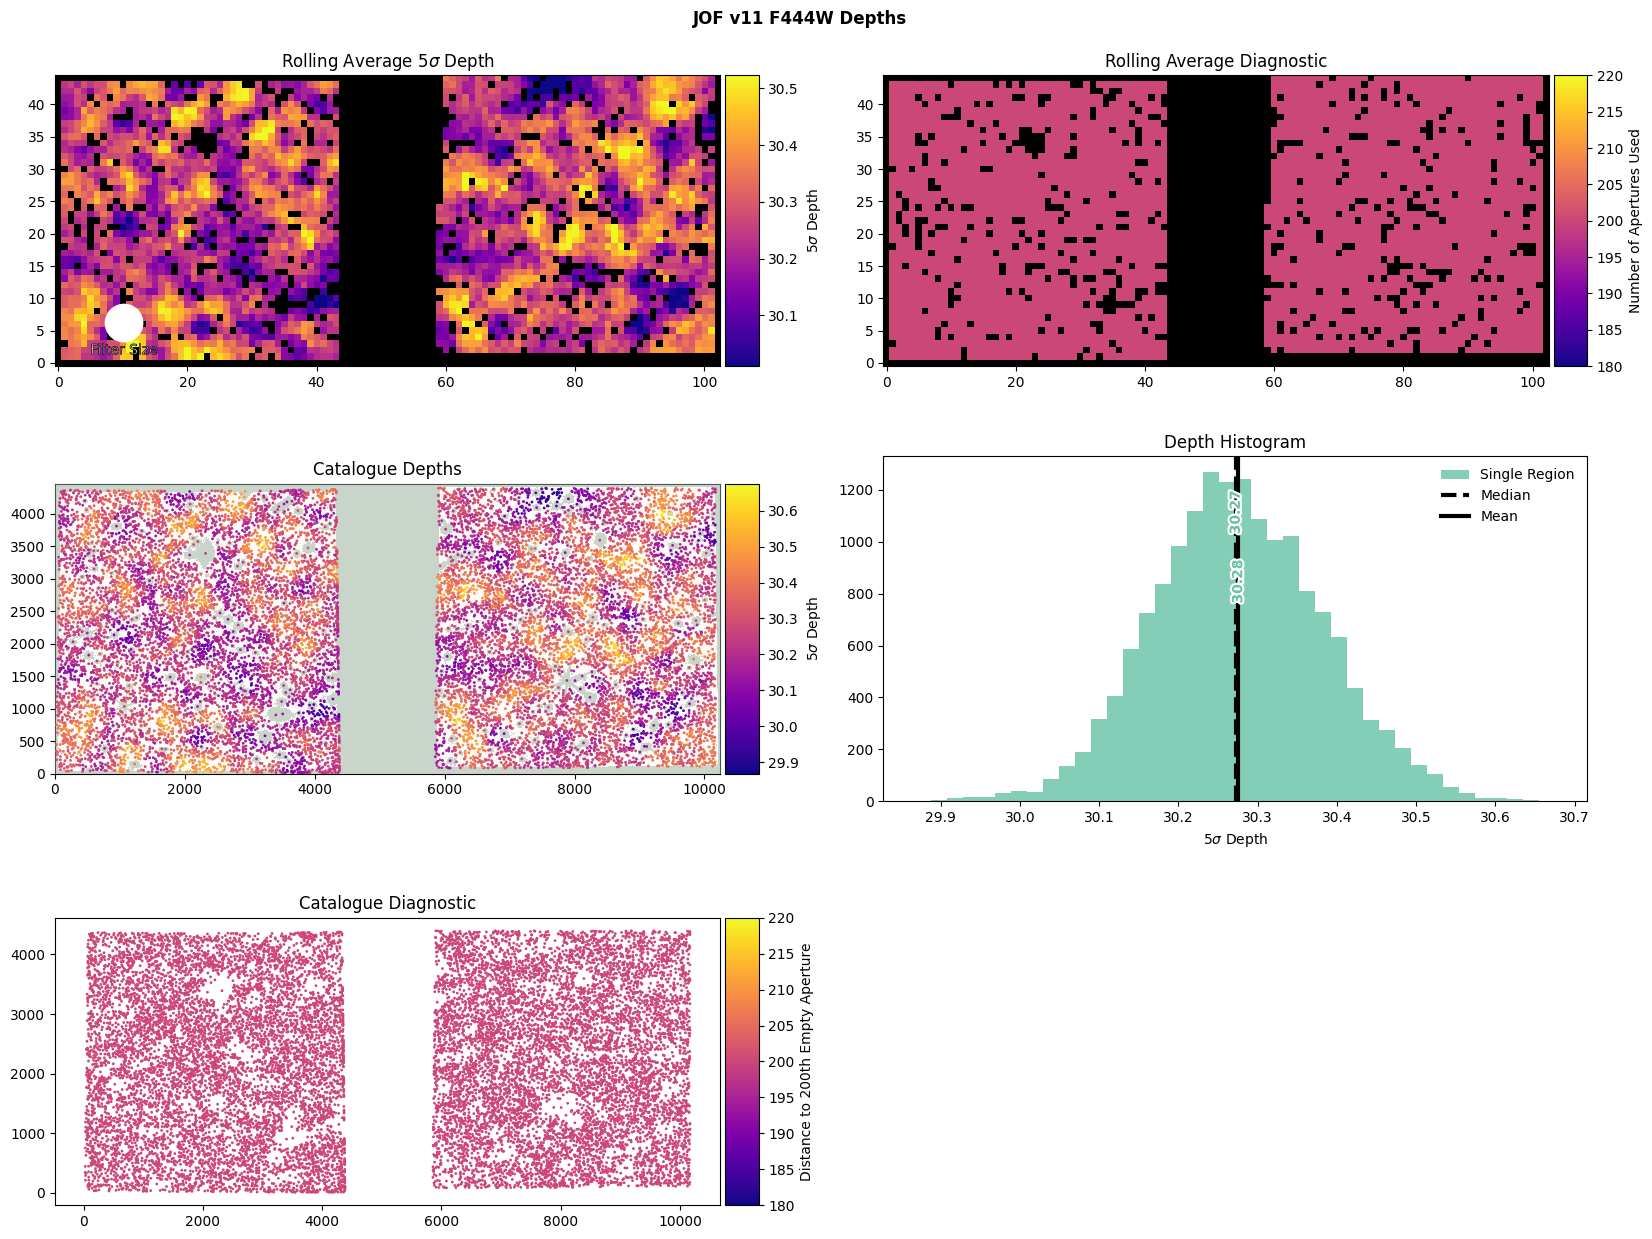

In [5]:
plot_band = "F444W"
plot_aper_diam = 0.32 * u.arcsec
JOF_data.plot_depth_diagnostic(
    plot_band,
    plot_aper_diam,
    show=True,
    save=True
)

Now imagine that instead of inputting an aperture diameter to plot, we instead want to plot these diagnostic depth plots for all bands and aperture diameters included within the catalogue. We can do this using the `Data.plot_depth_diagnostics()` method. Note here the additional `s` at the end of the function name. 

In [6]:
JOF_data.plot_depth_diagnostics(save = True)

INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F090W.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F115W.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F150W.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F162M.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F182M.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F200W.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/plots/F210M.png
INFO:galfind:Saved depths plot to /raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In addition, we also include functionality in the `Band_Data_Base` class to plot each of these diagnostic plots individually. These are accessed via the `plot_depths` method using the `plot_type` argument, which must be one of `rolling_average`, `rolling_average_diag`, `labels`, `hist`, `cat_depths`, or `cat_diag`.

## Example 3: Comparing different methods to run depths

Now that we have learnt how to run and plot the depth diagnostics for a specific survey, we will now test how different the depths will look if we instead choose an alternative method to compute them. First of all, we will need to produce a `v11_test` version of the same JOF data object to ensure that we do not overwrite the original `v11` JOF depths.

In [7]:
JOF_data_2 = Data.from_survey_version(
    survey=survey,
    version=f"{version}_test",
    instrument_names=instrument_names,
    version_to_dir_dict=morgan_version_to_dir,
    aper_diams=aper_diams,
    forced_phot_band=forced_phot_band,
)
JOF_data_2.mask()
JOF_data_2.segment()
JOF_data_2.perform_forced_phot()

INFO:galfind:Aperture corrections for NIRCam loaded from /nvme/scratch/work/austind/GALFIND/galfind/Aperture_corrections/NIRCam_aper_corr.txt


INFO:galfind:Loaded aper_diams=<Quantity [0.32] arcsec> for F277W+F356W+F444W
INFO:galfind:Combined mask for <galfind.Data.Stacked_Band_Data object at 0x7fcee6a92430> already exists at /raid/scratch/work/austind/GALFIND_WORK/Masks/JOF/combined/JOF_F277W+F356W+F444W_auto.fits


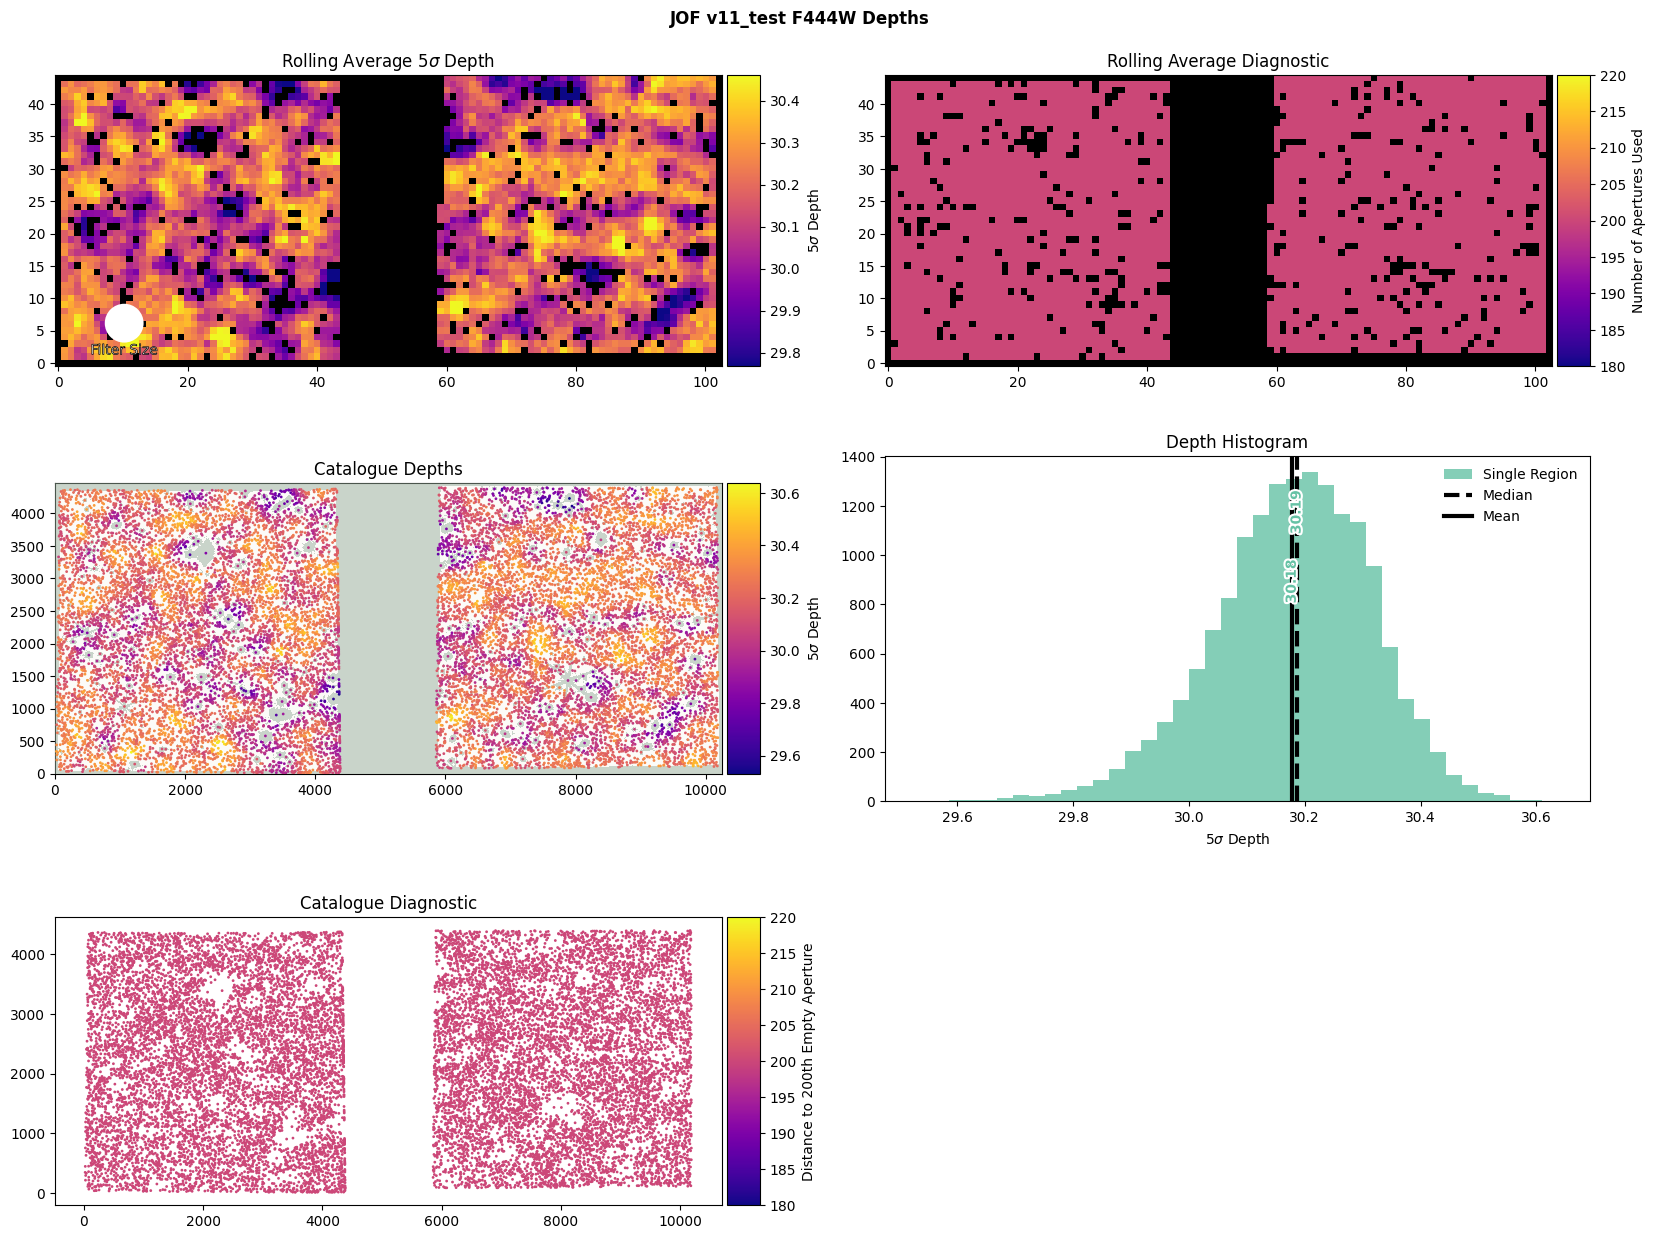

In [8]:
JOF_F444W_2 = JOF_data_2["F444W"]
JOF_F444W_2.run_depths(
    distance_to_mask = 10,
)
JOF_F444W_2.plot_depth_diagnostic(aper_diams[0], show = True)

Now let's compare the difference between the two versions. Let's analyze their differences in two plots.

1. A histogram of depth regions for each version on the same axis, labelled appropriately in the legend.
2. A 2D difference between the $5\sigma$ depths in each case.

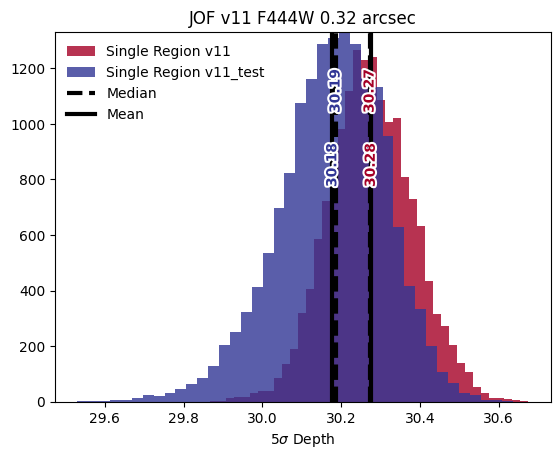

In [9]:
fig, ax = plt.subplots()
JOF_F444W.plot_depths(aper_diams[0], "hist", fig, ax, save = False, \
    show = False, cmap_name = "RdYlBu", label_suffix = "v11")
JOF_F444W_2.plot_depths(aper_diams[0], "hist", fig, ax, save = False, \
    show = True, cmap_name = "RdYlBu_r", label_suffix = "v11_test", 
    title = f"{JOF_F444W.survey} {JOF_F444W.version} {JOF_F444W.filt_name} {JOF_F444W.aper_diams[0]}")

/tmp/ipykernel_80080/307766086.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap("plasma"),


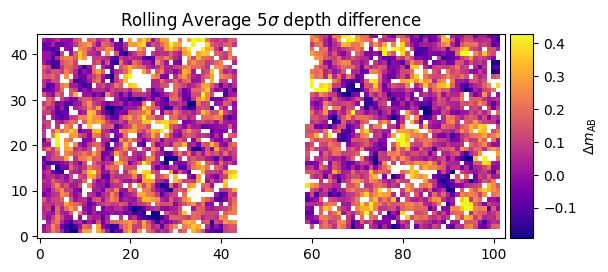

In [10]:
v11_hf_output = JOF_F444W.get_hf_output(aper_diams[0])
v11_test_hf_output = JOF_F444W_2.get_hf_output(aper_diams[0])
assert v11_hf_output["nmad_grid"].shape == \
    v11_test_hf_output["nmad_grid"].shape
nmad_grid_diff = v11_hf_output["nmad_grid"] - v11_test_hf_output["nmad_grid"]

fig, ax = plt.subplots()

vmin, vmax = (
    np.nanpercentile(nmad_grid_diff, 1),
    np.nanpercentile(nmad_grid_diff, 99),
)
mappable = ax.imshow(
    nmad_grid_diff, 
    origin="lower", 
    cmap=cm.get_cmap("plasma"), 
    vmin=vmin, vmax=vmax
)
# Make colorbar same height as ax
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable, label=r"$\Delta m_{\mathrm{AB}}$", cax=cax)
ax.set_title(r"Rolling Average 5$\sigma$ depth difference")
plt.show()

Unfortunately plot number 2 is a little bit of a handful compared to plot number 1, although it is still made much easier using the `Band_Data_Base` methods.